# Manutenção Preditiva




In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

Primeiro é carregado os dados com as categorias de falha já definidas, esse conjunto de dados é dividido em 80% para treinamento e 20% para teste.  

In [3]:
# Load the training data
sensor_data = pd.read_csv("./dados/desafio_manutencao_preditiva_treino.csv", index_col = 'udi')

# Load the test data
test_data = pd.read_csv("./dados/desafio_manutencao_preditiva_teste.csv", index_col = 'udi')

#%% Get resume of failure modes

print(sensor_data[['product_id', 'failure_type']].groupby('failure_type').count())

#%% Remove id columns 

sensor_data.drop(columns='product_id', inplace=True)

test_data.drop(columns='product_id', inplace=True)

                          product_id
failure_type                        
Heat Dissipation Failure          75
No Failure                      6435
Overstrain Failure                52
Power Failure                     63
Random Failures                   12
Tool Wear Failure                 30


In [4]:
sensor_data.columns

Index(['type', 'air_temperature_k', 'process_temperature_k',
       'rotational_speed_rpm', 'torque_nm', 'tool_wear_min', 'failure_type'],
      dtype='object')

O problema encontrado nos dados de manutenção preditiva é a classificação do tipo de falha que uma máquina pode ocasionar a partir de dados de sensores.

Para realizar o processo de classificação é escolhido aplicar o método SVM - Máquinas de vetores de suporte. Essa escolha se dá pelo método ter alta capacidade de generalização e conseguir se adequar bem a conjunto de dados não homogêneos (ajustando a função de erro para penalizar os erros causados pelas classes minoritárias), um ponto a ser levado em conta é que o modelo não é de tão fácil interpretação e pode ser sensível a modificações de parâmetros.

A fim de avaliar qual o conjunto de parâmetros mais infere o tipo de falha é escolhido o parâmetro F1, principalmente porque o conjunto de dados não é homogeneamente distribuido, com os valores de "Sem falha" sendo a maior parte dos dados. Nesse caso a acurácia de teste pode não representar muito bem o conjunto de dados.


Após a modificada as categorias para valores numéricos.

In [5]:
#%% Change class columns to fixed labels:
    
le = preprocessing.LabelEncoder()

le.fit(sensor_data.type)
sensor_data['type_numeric'] = le.transform(sensor_data.type)

le.fit(test_data.type)
test_data['type_numeric'] = le.transform(test_data.type)

le.fit(sensor_data.failure_type)
sensor_data['failure_type_numeric'] = le.transform(sensor_data.failure_type)

sensor_data.drop(columns = ['type', 'failure_type'], inplace=True)
test_data.drop(columns = ['type'], inplace=True)

Para verificar a relação entre cada variável será plotado gráfico de pares para cada tipo de falha.

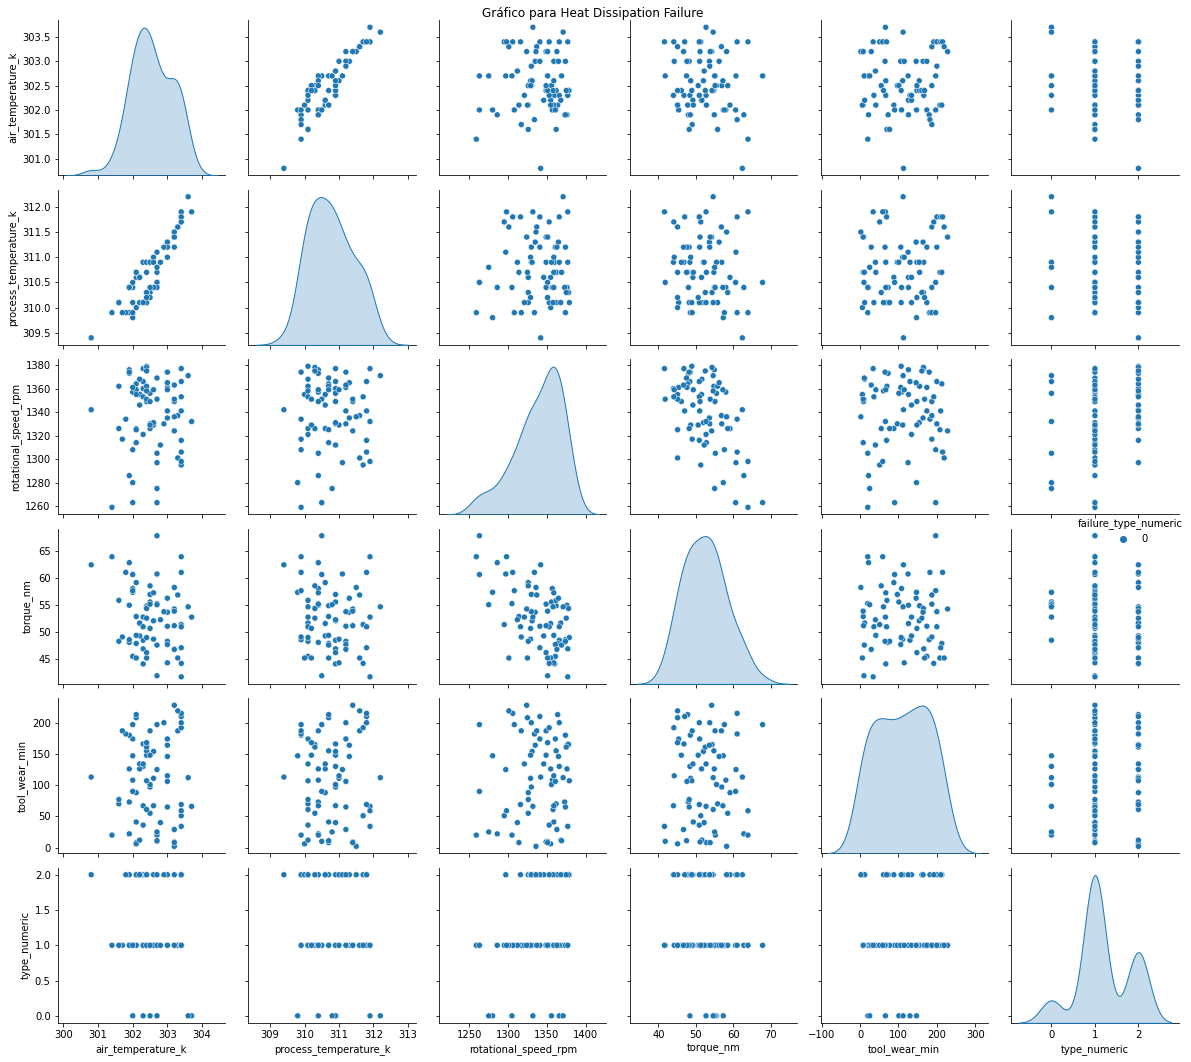

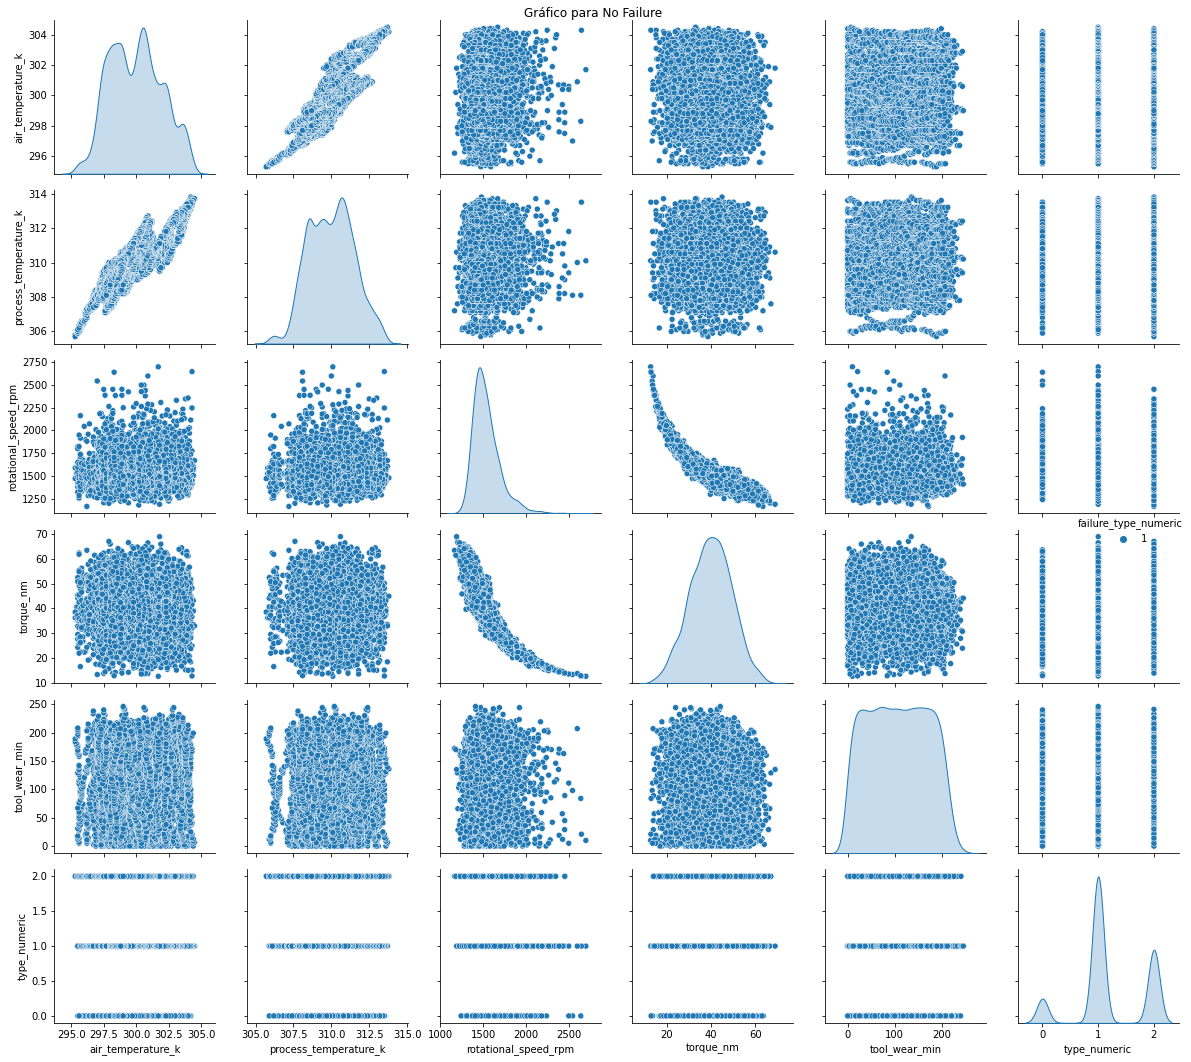

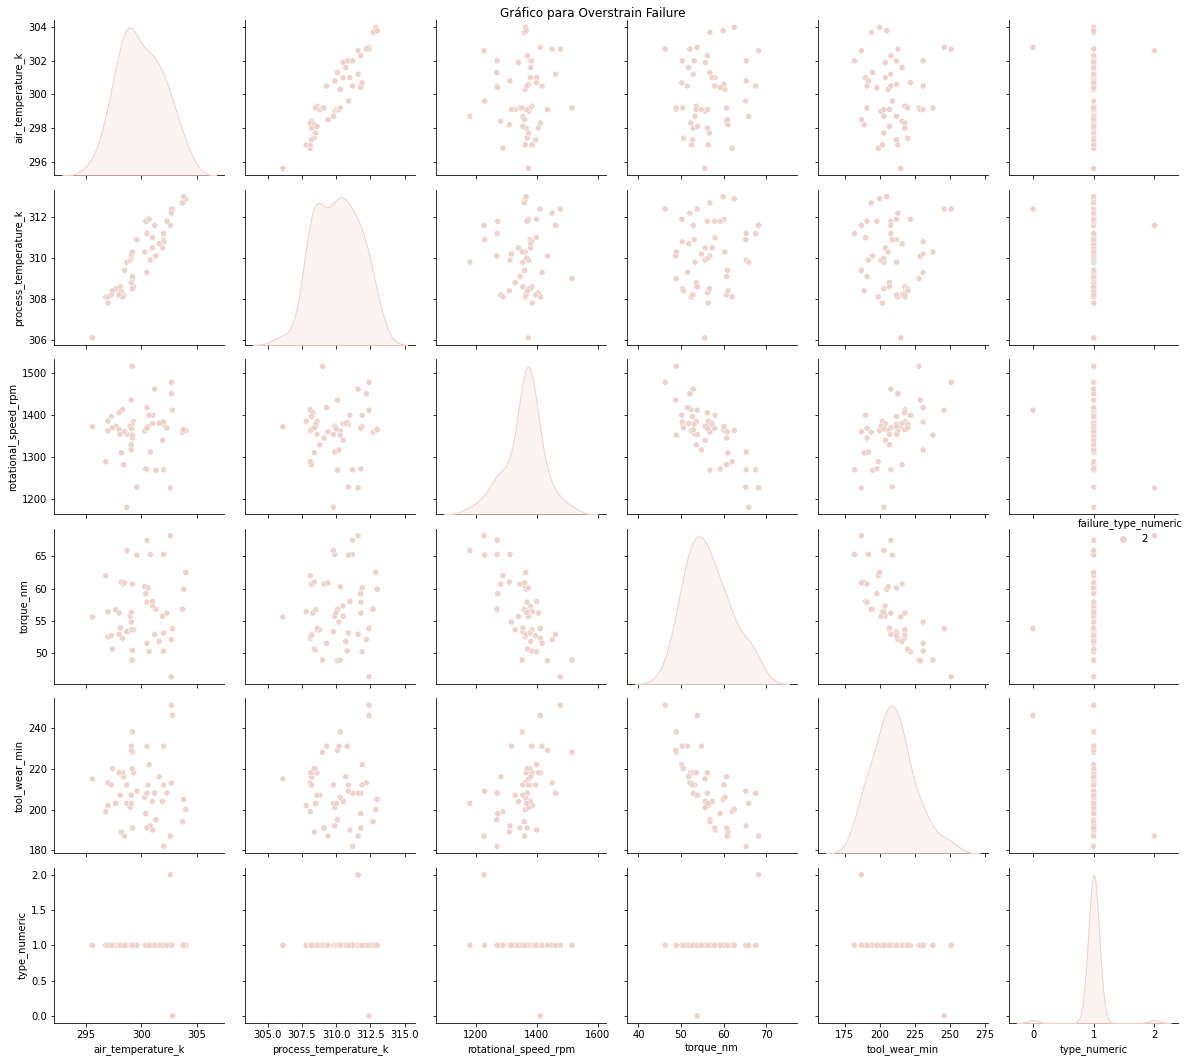

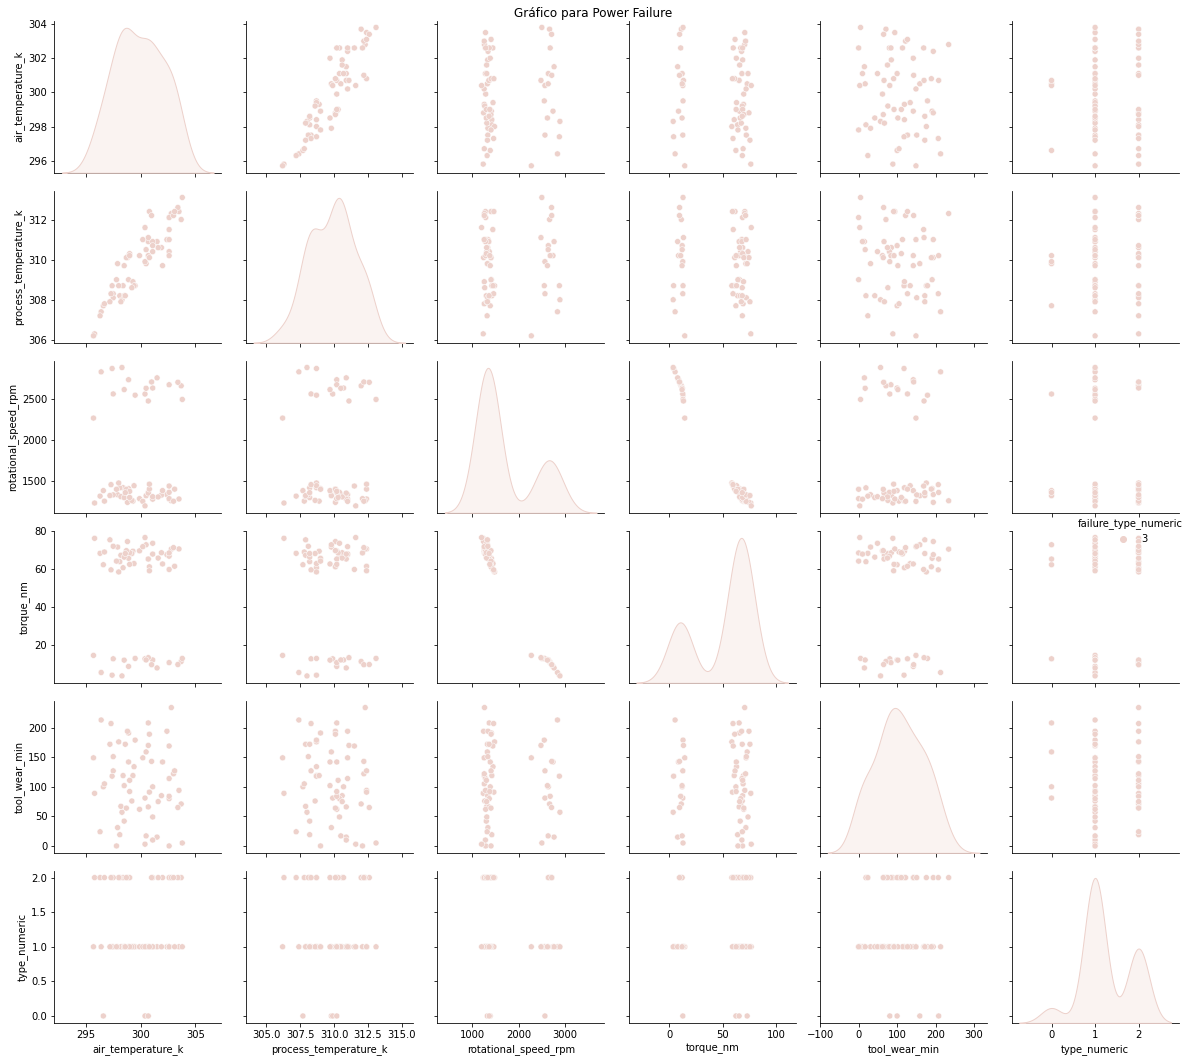

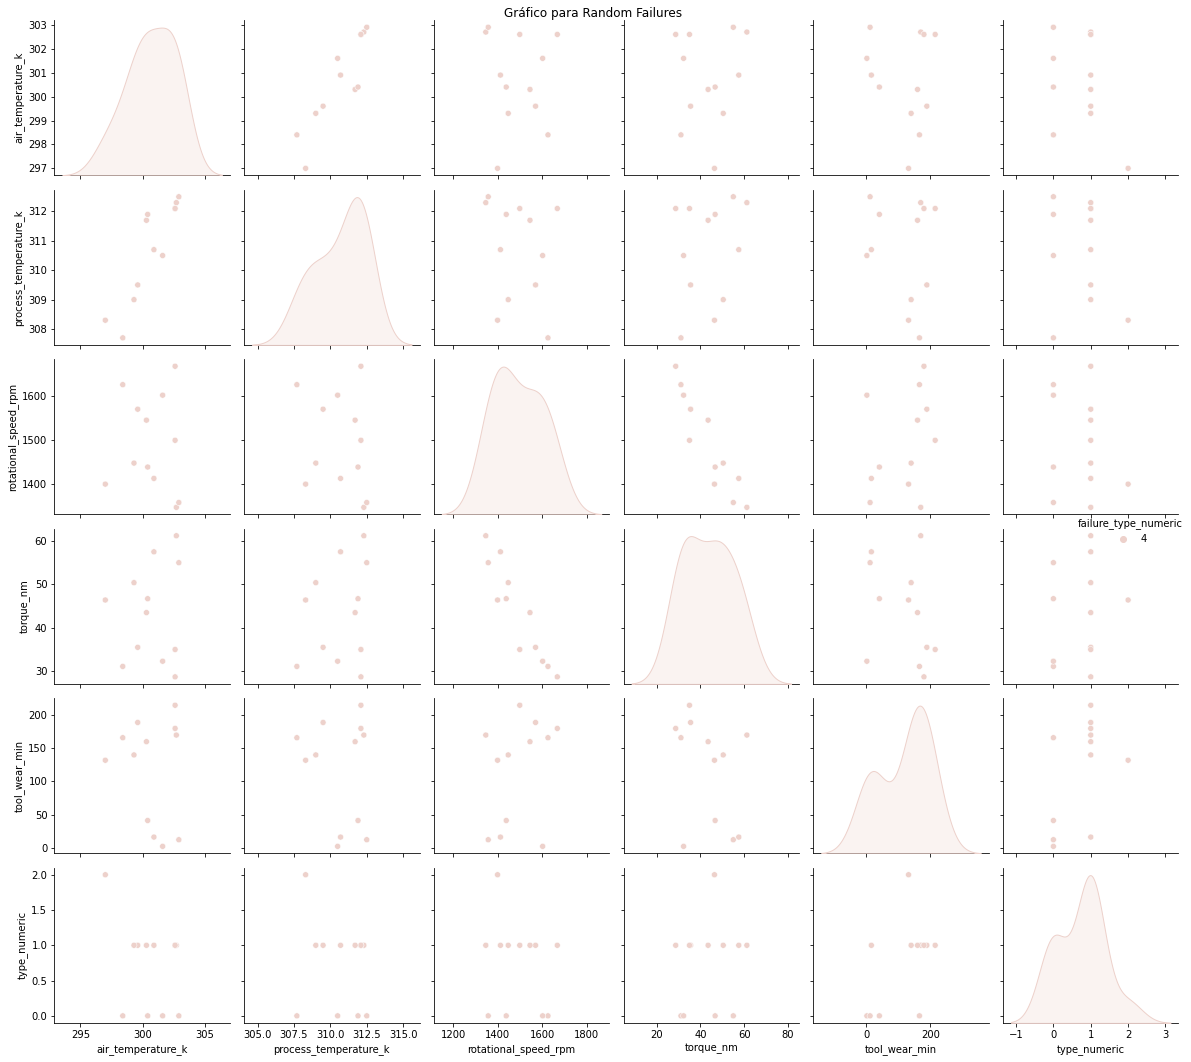

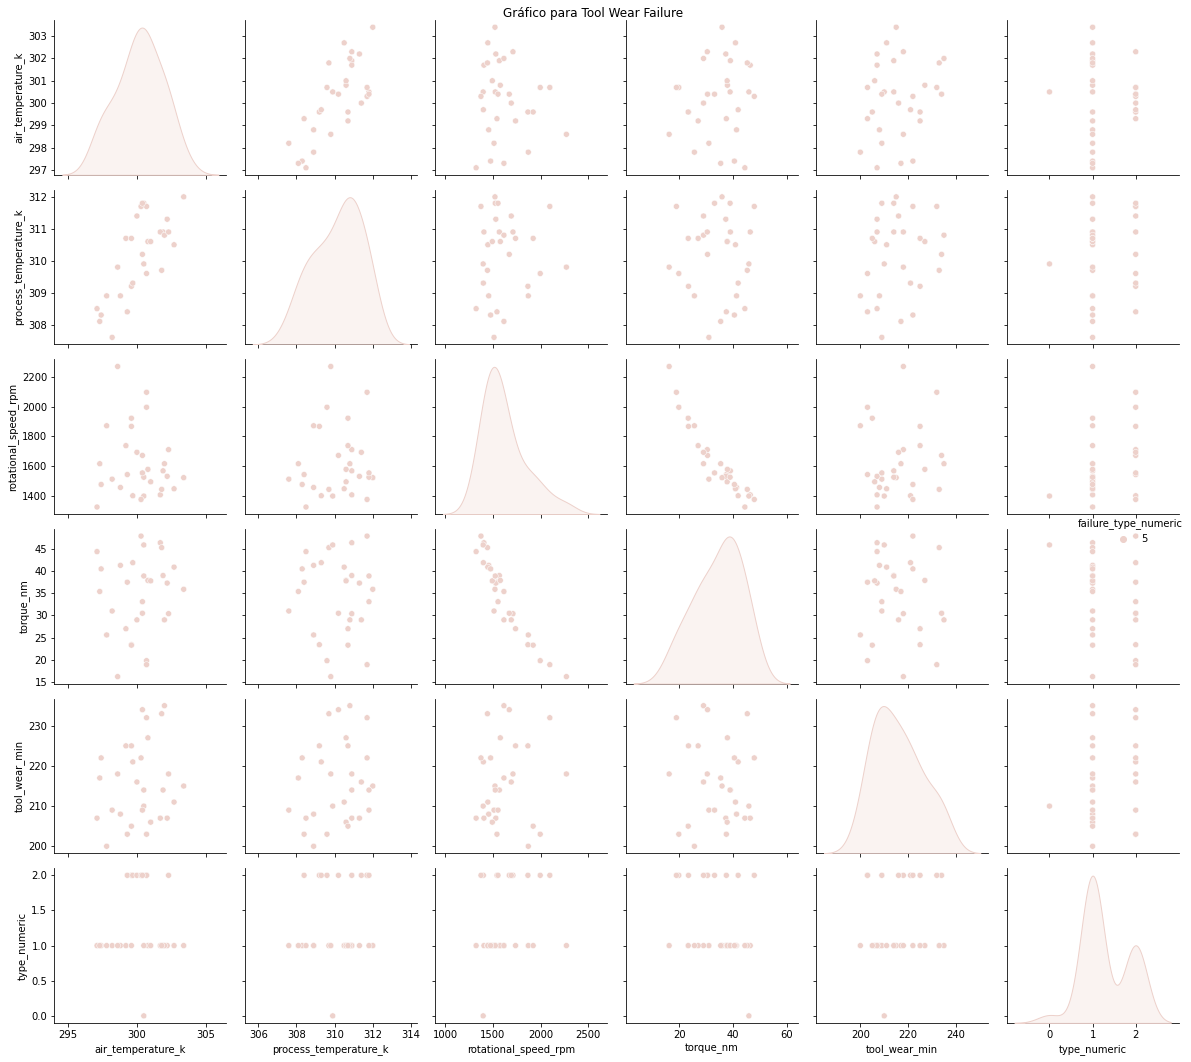

In [6]:
for i in range(len(sensor_data['failure_type_numeric'].unique())):

    graph = sns.pairplot(sensor_data[sensor_data['failure_type_numeric'] == i], hue='failure_type_numeric')
    
    graph.fig.suptitle(f'Gráfico para {le.inverse_transform([i])[0]}')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()

Com a análise de cada tipo de falha é possível perceber que diferentes tipos de falha resultam de uma combinação de diferentes fatores. Destacam-se:

1. Heat Dissipation Failure: indicadas principalmente pela temperatura de processo, onde que percebe-se um desvio para a direita
2. Overstrain Failure: a característica mais destacada no conjunto é de que todos os defeitos encontrados são provenientes da máquina tipo 1, além de termos uma relação próxima a linear entre torque e rotação e desgaste da ferramenta.
3. Power Failure: a caracterísitica de velocidade de rotação, desgaste da ferramenta e de torque definem o conjunto de fatores que levam a máquina a falha, verifica-se claramente nos gráficos um agrupamento de dados em torno dos valores mínimo e máximo destes fatores. 

A partir da visualização geral é possível destacar o torque e a velocidade de rotação como carcaterísticas de classificação geral, mas é importante ressaltar que parâmetros como temperatura de processo e tipo de máquina também são modificados dependendo do tipo de falha.

----

A primeira tentativa de modelo se dá com o uso de todas as características para avaliação.


In [23]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
}

features = sensor_data.iloc[:,:-1].values

labels = sensor_data.iloc[:,-1].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create a SVM object
svm = SVC()

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by the GridSearchCV object
print('Best hyperparameters:', grid_search.best_params_)


Best hyperparameters: {'kernel': 'linear'}


In [29]:
def train_data(input_df):

    # All parameters

    features = input_df.values

    labels = sensor_data.iloc[:,-1].values

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train a SVM classifier on the training data
    clf = SVC(kernel='linear', random_state=42)
    clf.fit(X_train, y_train)

    # Predict the labels of the test data
    y_pred = clf.predict(X_test)

    # Compute the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)

    f1 = f1_score(y_test, y_pred, average=None)
    print("F1 score: ", accuracy)

    precision = precision_score(y_test, y_pred, average=None)
    print("Precision: ", accuracy)

    recall = recall_score(y_test, y_pred, average=None)
    print("Recall: ", recall)
    
    return clf
    
all_parameters = train_data(sensor_data.iloc[:,:-1])

Accuracy:  0.9812593703148426
F1 score:  0.9812593703148426
Precision:  0.9812593703148426
Recall:  [0.5        0.99381284 0.81818182 0.81818182 0.         0.        ]


/home/julia/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
## 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min', 'type_numeric'

parameters_1 = train_data(sensor_data[['process_temperature_k', 'rotational_speed_rpm',
       'torque_nm', 'tool_wear_min', 'type_numeric']])

Accuracy:  0.97976011994003
F1 score:  0.97976011994003
Precision:  0.97976011994003
Recall:  [0.         0.99845321 0.81818182 0.63636364 0.         0.        ]


/home/julia/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
##'rotational_speed_rpm', 'torque_nm', 'tool_wear_min'

parameters_2 = train_data(sensor_data[['rotational_speed_rpm',
       'torque_nm', 'tool_wear_min', 'type_numeric']])

Accuracy:  0.9812593703148426
F1 score:  0.9812593703148426
Precision:  0.9812593703148426
Recall:  [0.         0.99613302 1.         0.90909091 0.         0.        ]


/home/julia/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nessa verificação, retira-se o parâmetro de temperatura como fatore importante para a classificação, visto que o parâmetro F1 sem essa coluna de dados é igual ao com todas as colunas.

In [32]:
##rotational_speed_rpm, torque_nm

parameters_3 = train_data(sensor_data[['rotational_speed_rpm', 'torque_nm']])

Accuracy:  0.9760119940029985
F1 score:  0.9760119940029985
Precision:  0.9760119940029985
Recall:  [0.         0.9992266  0.         0.90909091 0.         0.        ]


/home/julia/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Além disso, verifica-se que os outros parâmetros mantidos são importantes para a classificação correta do modelo.

In [33]:
##'rotational_speed_rpm', 'torque_nm', 'tool_wear_min'

# Make predictions
predictions = parameters_2.predict(test_data[['rotational_speed_rpm',
       'torque_nm', 'tool_wear_min', 'type_numeric']])

test_data['failure_type'] = le.inverse_transform(predictions)

In [41]:
predict_df = test_data['failure_type']

predict_df.to_csv('predicted.csv', index_label="rowNumber")